# **Modelling and Evaluation**

---

## Objectives

* Answer business requirement 2:
    * Develop a machine learning model for automating image categorization, leveraging CNN architecture for efficient and scalable classification.

* Answer Business Requirement 3:
    * Evaluate the model's performance by assessing its accuracy and loss metrics.

## Inputs

* inputs/cifar10_dataset_small/train
* inputs/cifar10_dataset_small/validation
* inputs/cifar10_dataset_small/test
* image shape embeddings

## Outputs

* Class distribution plots for training, validation, and test sets.
* Image augmentation
* Development and training of the machine learning model
* Learning curve plot for model performance.
* Model evaluation saved as a pickle file.

---

## Install packages and libraries

In [1]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
import pickle


## Change and Set directories

We need to change the working directory from its current folder to its parent folder


In [2]:
current_dir = os.getcwd()
print('Current folder: ' + current_dir)
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print('New folder: ' + current_dir)

Current folder: /workspace/SnapSortAI/jupyter_notebooks
New folder: /workspace/SnapSortAI


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/SnapSortAI'

### Input directories and paths

In [4]:
dataset_root_dir = 'inputs/cifar10_dataset_small'
train_path = dataset_root_dir + '/train'
validation_path = dataset_root_dir + '/validation'
test_path = dataset_root_dir + '/test'
train_path

'inputs/cifar10_dataset_small/train'

### Set output directory

In [5]:
version = 'v7'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print(f'Version {version} is already available.')
    pass
else:
    os.makedirs(name=file_path)
    print(f'New directory for version {version} has been created')

Version v7 is already available.


### Set label names

In [6]:
labels = os.listdir(train_path)
labels.sort()
print("Class names:", labels)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Set image shape

In [7]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(32, 32, 3)

---

## Image Distribution in Train, Test and Validation Data

---

Let's recap on the plot from the previous notebook:

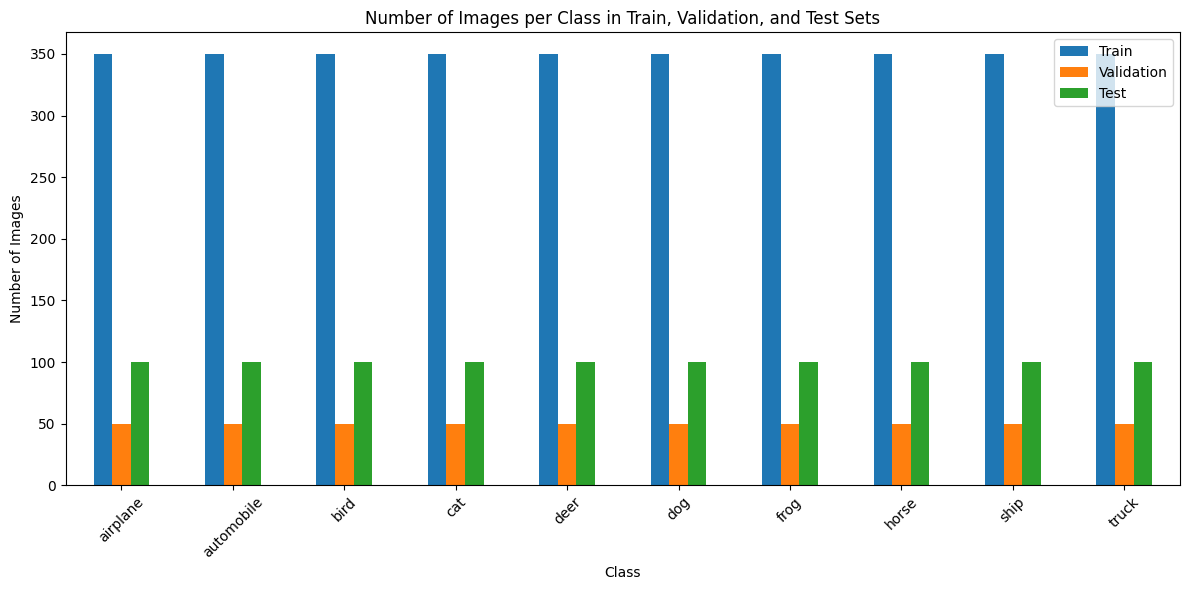

In [8]:
def count_images_in_path(path):
    """
    Counts the number of images in each class folder within the given path.

    Args:
        path (str): The directory path containing subfolders for each class.

    Returns:
        dict: A dictionary where keys are class labels (subfolder names) and values are the number of images in each class.
    
    """
    class_counts = {}
    for label in labels:
        label_path = os.path.join(path, label)
        class_counts[label] = len(os.listdir(label_path))
    return class_counts

# Count images in datasets
train_counts = count_images_in_path(train_path)
validation_counts = count_images_in_path(validation_path)
test_counts = count_images_in_path(test_path)

# Convert to DataFrame for plotting
train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train'])
validation_df = pd.DataFrame(list(validation_counts.items()), columns=['Class', 'Validation'])
test_df = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Test'])

# Merge dataframes for visualization
df = pd.merge(train_df, validation_df, on='Class')
df = pd.merge(df, test_df, on='Class')

df.set_index('Class').plot(kind='bar', figsize=(12, 6))
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Train, Validation, and Test Sets')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

---

## Image Data Augmentation

---

### Initialize image data generator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set this to False to skip augmentation for the first model training
use_augmentation = True

if use_augmentation:
    # Use image augmentation
    augmented_image_data = ImageDataGenerator(
                            rotation_range=15,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            zoom_range=[0.8, 1.2],
                            horizontal_flip=True,
                            rescale=1./255
    )
else:
    # Only normalize the images, no augmentation
    augmented_image_data = ImageDataGenerator(rescale=1./255)

### Augment training, validation and test image datasets

In [10]:
batch_size = 32

# Prepare the training set
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

# Validation and Test sets always just normalized, no augmentation
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

Found 3500 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


### Plot augmented training image

(32, 32, 32, 3)


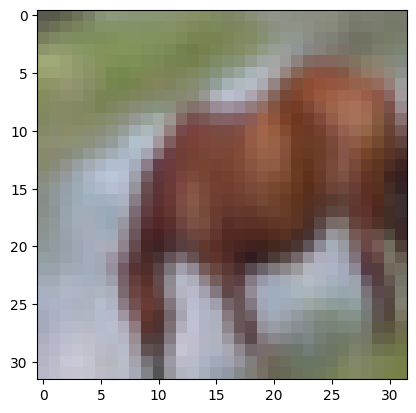

(32, 32, 32, 3)


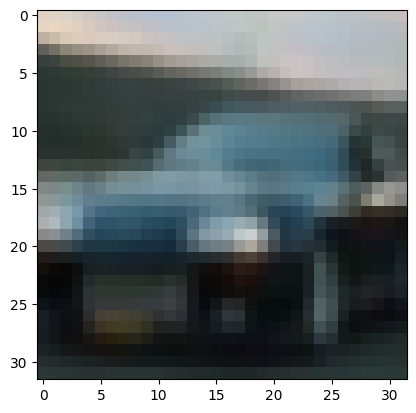

(32, 32, 32, 3)


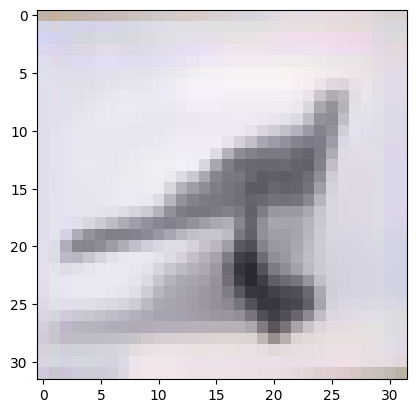

In [11]:
# Training set
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation and test images

(32, 32, 32, 3)


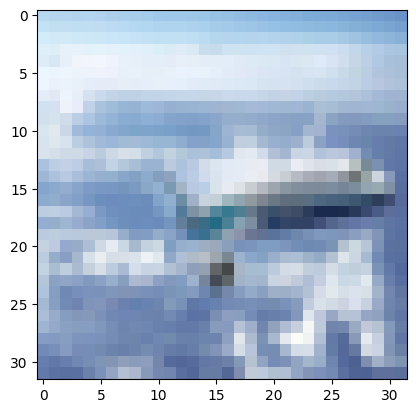

(32, 32, 32, 3)


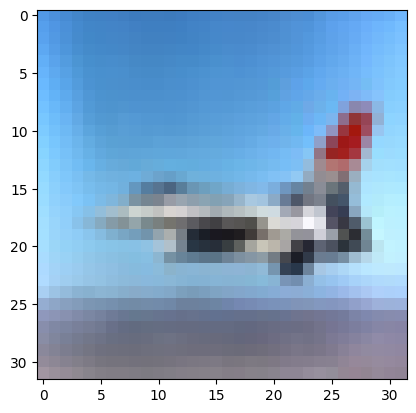

(32, 32, 32, 3)


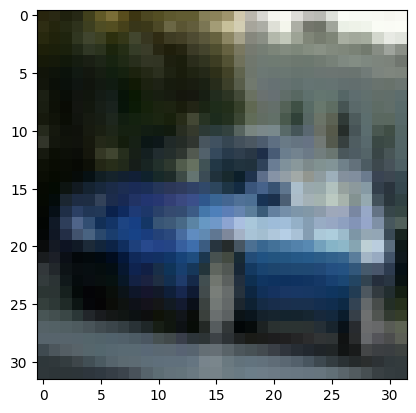

(32, 32, 32, 3)


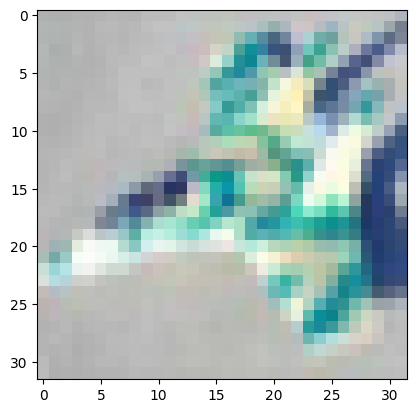

(32, 32, 32, 3)


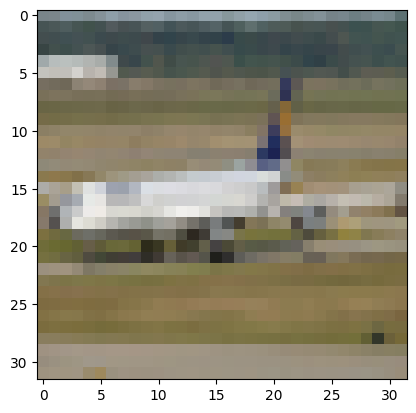

(32, 32, 32, 3)


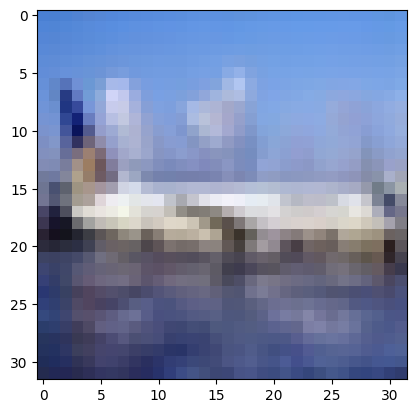

In [12]:
# Validation set
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

# Test set
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


### Save class indicies

In [13]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v7/class_indices.pkl']

---

## Model Creation

---

### ML model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers

def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=image_shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

### Summary

In [15]:

create_tf_model().summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         2

2024-09-23 11:43:38.132111: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Early Stopping

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=15)

### Fit Model For Model Training

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = create_tf_model()
history = model.fit(train_set,
                    epochs=100,
                    steps_per_epoch=train_set.samples // batch_size,
                    validation_data=validation_set,
                    callbacks=[
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
                        EarlyStopping(monitor='val_loss', patience=15)
                    ],
                    verbose=1
                    )

2024-09-23 11:43:38.487226: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
109/109 [==============================] - 26s 233ms/step - loss: 13.7316 - accuracy: 0.2471 - val_loss: 14.9442 - val_accuracy: 0.1000
Epoch 2/100
109/109 [==============================] - 24s 222ms/step - loss: 9.2435 - accuracy: 0.3114 - val_loss: 9.8446 - val_accuracy: 0.1480
Epoch 3/100
109/109 [==============================] - 24s 217ms/step - loss: 6.5514 - accuracy: 0.3411 - val_loss: 6.7692 - val_accuracy: 0.1840
Epoch 4/100
109/109 [==============================] - 23s 214ms/step - loss: 5.2113 - accuracy: 0.3625 - val_loss: 4.7634 - val_accuracy: 0.2860
Epoch 5/100
109/109 [==============================] - 23s 213ms/step - loss: 4.2664 - accuracy: 0.3979 - val_loss: 4.1545 - val_accuracy: 0.3100
Epoch 6/100
109/109 [==============================] - 23s 214ms/step - loss: 3.6098 - accuracy: 0.4354 - val_loss: 3.4048 - val_accuracy: 0.4420
Epoch 7/100
109/109 [==============================] - 23s 214ms/step - loss: 3.3441 - accuracy: 0.4354 - val_loss: 3.3639

### Save Model

In [18]:
model.save(f'{file_path}/snapsort_model.h5')

---

## Model Performance

---

### Model Learning Curve

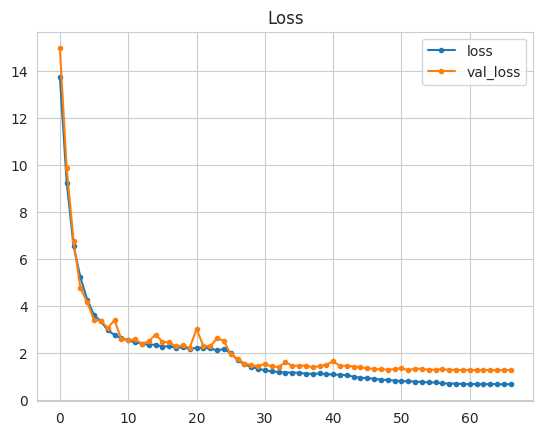

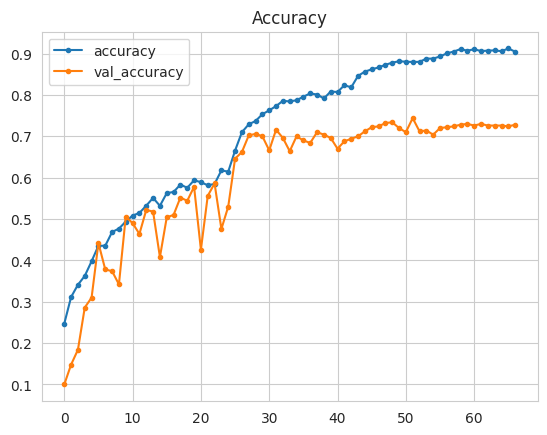

In [19]:

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model Evaluation

#### Load model

In [20]:
from keras.models import load_model
model = load_model(f'{file_path}/snapsort_model.h5')

#### Evaluate on the test set

In [21]:
evaluation = model.evaluate(test_set)

32/32 [==============================] - 2s 48ms/step - loss: 1.4201 - accuracy: 0.7110


#### Save Evaluation

In [22]:
joblib.dump(value=evaluation,
            filename=f'{file_path}/evaluation.pkl')

['outputs/v7/evaluation.pkl']

### Predict On New Data

#### Load a random image as PIL

Image shape: (32, 32), Image mode: RGB


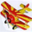

In [23]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

#### Convert image to array

In [24]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 32, 32, 3)


#### Predict class for the image

Predicted Probabilities: [9.3016618e-01 6.9018945e-02 3.1836687e-05 2.4170195e-08 3.9538409e-06
 1.0290820e-07 2.1090852e-04 1.3443827e-06 3.0021774e-04 2.6656175e-04]
Predicted Class: airplane


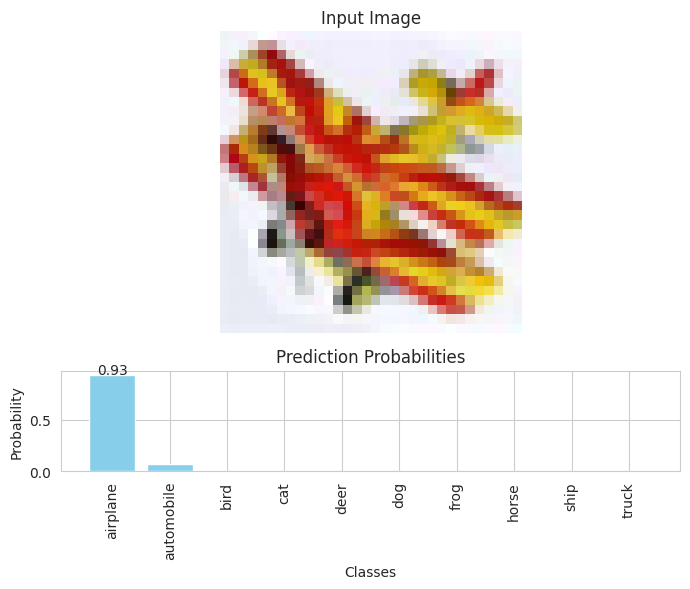

In [25]:
# Predict probabilities
pred_proba = model.predict(my_image)[0]

# Map indices to class names
target_map = {v: k for k, v in train_set.class_indices.items()}

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(pred_proba)
pred_class = target_map[predicted_class_index]

print("Predicted Probabilities:", pred_proba)
print("Predicted Class:", pred_class)

fig, axs = plt.subplots(2, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1]})

# Display the input image
axs[0].imshow(pil_image)
axs[0].set_title('Input Image')
axs[0].axis('off')

# Plot the prediction probabilities
axs[1].bar(range(len(labels)), pred_proba, color='skyblue')
axs[1].set_title('Prediction Probabilities')
axs[1].set_xlabel('Classes')
axs[1].set_ylabel('Probability')

# Show all class labels
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=90)

# Add the probability value next to the bar for the predicted class
axs[1].text(predicted_class_index, pred_proba[predicted_class_index] + 0.01, 
            f'{pred_proba[predicted_class_index]:.2f}', ha='center')

plt.tight_layout()
plt.show()


---

## Push Files To Repo

Add to gitignore:

View changed files:

In [26]:
#!git status

Add, commit and push your files to the repo (all or single files):

In [27]:
#!git add .

#!git commit -m "Message"

---

## Conclusions

---

### **Model v1:** (Without augmented data)

**Model Performance on Test Set:**
- **Final Test Accuracy:** Approximately X.XX%
- **Final Test Loss:** X.XXXX

**Summary:**
- **Training Accuracy (after 18 epochs):** Approximately 73.54%
- **Validation Accuracy (after 18 epochs):** Approximately 56.00%
- **Test Accuracy:** Approximately 50.00% 

**Training Time:**
- **Time per Epoch:** Approximately 5 seconds
- **Total Time for 18 Epochs:** 90 seconds (or about 1.5 minutes)

**Model Architecture:**
- **Conv2D Layers:** Filters → 32 → 64 → 64

**Model Summary:**
- **Trainable Parameters:** 90,506
- **Model Size:** 
  - 90,506 params × 4 bytes/param = 362,024 bytes ≈ 0.36 MB

---

### **Model v1.5:** (With augmented data)

**Model Performance on Test Set:**
- **Final Test Accuracy:** Approximately 40.90%
- **Final Test Loss:** 1.5921

 **Summary:**
- **Training Accuracy (after 15 epochs):** Approximately 39.60%
- **Validation Accuracy (after 15 epochs):** Approximately 39.40%
- **Test Accuracy:** Approximately 40.90%

**Training Time:**
- **Time per Epoch:** Approximately 5 seconds
- **Total Time for 15 Epochs:** 75 seconds (or about 1.25 minutes)

**Model Architecture:**
- **Conv2D Layers:** Filters → 32 → 64 → 64

**Model Summary:**
- **Trainable Parameters:** 90,506
- **Model Size:** 
  - 90,506 params × 4 bytes/param = 362,024 bytes ≈ 0.36 MB

---

### **Model v2:** (Without augmented data)

**Model Performance on Test Set:**
- **Final Test Accuracy:** Approximately 50.90%
- **Final Test Loss:** 1.5637

**Summary:**
- **Training Accuracy (after 25 epochs):** Approximately 70.26%
- **Validation Accuracy (after 25 epochs):** Approximately 51.60%
- **Test Accuracy:** Approximately 50.90%

**Training Time:**
- **Time per Epoch:** Approximately 5 seconds
- **Total Time for 25 Epochs:** 5 seconds/epoch × 25 epochs = 125 seconds (or about 2.08 minutes)

**Model Architecture:**
- **Conv2D Layers:** Filters → 32 → 64 → 64 → 128 (with Batch Normalization)

**Model Summary:**
- **Trainable Parameters:** 90,506
- **Model Size:** 
  - 90,506 params × 4 bytes/param = 362,024 bytes ≈ 0.36 MB

---

### **Model v3:** (With augmented data)

**Model Performance on Test Set:**
- **Final Test Accuracy:** Approximately 43.40%
- **Final Test Loss:** 1.5835

**Summary:**
- **Training Accuracy (after 21 epochs):** Approximately 70.26%
- **Validation Accuracy (after 21 epochs):** Approximately 51.60%
- **Test Accuracy:** Approximately 43.40%

**Training Time:**
- **Time per Epoch:** Approximately 5 seconds
- **Total Time for 21 Epochs:** 5 seconds/epoch × 21 epochs = 105 seconds (or about 1.75 minutes)

**Model Architecture:**
- **Conv2D Layers:** Filters → 32 → 64 → 64 → 128 (with Batch Normalization)

**Model Summary:**
- **Trainable Parameters:** 147,978
- **Model Size:** 
  - 147,978 params × 4 bytes/param = 591,912 bytes ≈ 0.59 MB



---

### **Model v4:** (Without augmented data)

**Model Performance on Test Set:**
- **Final Test Accuracy:** Approximately 49.60%
- **Final Test Loss:** 2.1050

**Summary:**
- **Training Accuracy (after 25 epochs):** Approximately 89.63%
- **Validation Accuracy (after 25 epochs):** Approximately 54.20%
- **Test Accuracy:** Approximately 49.60%

**Training Time:**
- **Time per Epoch:** Approximately 16 seconds
- **Total Time for 25 Epochs:** 16 seconds/epoch × 25 epochs = 400 seconds (or about 6.67 minutes)

**Model Architecture:**
- **Conv2D Layers:** Filters → 64 → 128 → 128 → 256 (with Batch Normalization)
- **L2 Regularization:** Applied to the dense layer with a regularization strength of 0.01.

**Model Summary:**
- **Trainable Parameters:** 587,914
- **Model Size:** 
  - 587,914 params × 4 bytes/param = 2,351,656 bytes ≈ 2.35 MB

---

### **Model v5:** (Without augmented data)

**Model Performance on Test Set:**
- **Final Test Accuracy:** Approximately 62.60%
- **Final Test Loss:** 1.3020

**Summary:**
- **Training Accuracy (after 50 epochs):** Approximately 100%
- **Validation Accuracy (after 50 epochs):** Approximately 62.60%
- **Test Accuracy:** Approximately 62.60%

**Training Time:**
- **Time per Epoch:** Approximately 15–16 seconds
- **Total Time for 50 Epochs:** 16 seconds/epoch × 50 epochs = 800 seconds (or about 13.3 minutes)

**Model Architecture:**
- **Conv2D Layers:** Filters → 64 → 128 → 128 → 256 (with Batch Normalization)
- **MaxPooling:** Applied after every second Conv2D layer
- **L2 Regularization:** Applied to the dense layer with a regularization strength of 0.01
- **Dropout:** Rate = 0.5 (to prevent overfitting)
- **Dense Layer:** Units → 512 (with L2 Regularization)
- **Output Layer:** Dense → 10 units (softmax activation for classification)

**Model Summary:**
- **Trainable Parameters:** 587,914
- **Non-Trainable Parameters:** 1,152
- **Model Size:**
  - 587,914 params × 4 bytes/param = 2,351,656 bytes ≈ 2.35 MB


---

### **Model v6** (With augmented data)

**Model Performance on Test Set:**
- **Final Test Accuracy:** Approximately 67.20%
- **Final Test Loss:** 1.1917

**Summary:**
- **Training Accuracy (after 50 epochs):** Approximately 91.15%
- **Validation Accuracy (after 50 epochs):** Approximately 69.00%
- **Test Accuracy:** Approximately 67.20%

**Training Time:**
- **Time per Epoch:** Approximately 16-17 seconds
- **Total Time for 50 Epochs:** 16 seconds/epoch × 50 epochs = 800 seconds (or about 13.3 minutes)

**Data Augmentation:**
- **Rotation Range:** 15°
- **Width/Height Shift:** 5%
- **Zoom Range:** 0.8 to 1.2
- **Horizontal Flip:** Enabled
- **Rescale:** 1./255 (image normalization)

**Model Architecture:**
- **Conv2D Layers:** Filters → 64 → 128 → 128 → 256 (with Batch Normalization)
- **L2 Regularization:** Applied to the dense layer with a regularization strength of 0.01.

**Model Summary:**
- **Trainable Parameters:** 587,914
- **Model Size:** 
  - 587,914 params × 4 bytes/param = 2,351,656 bytes ≈ 2.35 MB
  
---

**Note:**
The model achieved a **5% increase in accuracy** on the test set (from 62.60% to 67.20%) when using data augmentation. This supports the hypothesis that **data augmentation improves model generalization** and enhances performance by introducing variability in the training dataset.

---


## **Final Model v7:** (With augmented data)

### Model Performance on Test Set
- **Final Test Accuracy:** Approximately 71.20%
- **Final Test Loss:** 1.2812

### Summary
- **Training Accuracy (after 64/100 epochs):** Approximately 92.45%
- **Validation Accuracy (after 64/100 epochs):** Approximately 73.00%
- **Test Accuracy:** Approximately 71.20%

### Training Time
- **Time per Epoch:** Approximately 25 seconds
- **Total Time for 64/100 Epochs:** 2,500 seconds (about 42 minutes)

### Training Summary
- **Total Epochs:** 100 (early stop = 64)
- **Early Stopping Patience:** 15 epochs without improvement on validation loss
- **Learning Rate Reduction:** Reduced by a factor of 0.2 after 5 epochs without improvement on validation loss

### Data Augmentation
- **Rotation Range:** 15°
- **Width/Height Shift:** 5%
- **Zoom Range:** 0.8 to 1.2
- **Horizontal Flip:** Enabled
- **Rescale:** 1./255 (image normalization)

### Model Architecture
- **Conv2D Layers:** 
  - 1st Layer: 64 filters
  - 2nd Layer: 128 filters
  - 3rd Layer: 256 filters
- **Batch Normalization:** Applied after each convolutional layer.
- **Max Pooling Layers:** 3 pooling layers to reduce dimensionality.
- **Dense Layer:** 512 units in the dense layer.

### Model Summary
- **Total Parameters:** 2,607,242
- **Trainable Parameters:** 2,604,810
- **Non-trainable Parameters:** 2,432

#### **Note:** The Model met the business criteria of 70% accuracy!
Further training can be done to improve performance, but the model has already achieved the target.
